In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from PIL import Image
from modules import dataset, vqvae, tools, pixelcnn

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Train the VQVAE model
### Load the data from dataset.

In [2]:
data_train, data_validate, data_test = dataset.load_data()
print(len(data_train))
print(len(data_validate))
print(len(data_test))

9664
1120
544


### Create image generator to pass to the vqvae model for training.

In [3]:
data_gen = dataset.data_generator(train_data = data_train, batch_size = 8)
validate_gen = dataset.validate_generator(validate_data = data_validate, batch_size = 8)

In [4]:
img= next(data_gen)
print(img.shape)
img = next(validate_gen)
print(img.shape)
print(len(data_train))
print(len(data_validate))

(8, 256, 256, 1)
(8, 256, 256, 1)
9664
1120


In [5]:
steps_per_epoch = len(data_train)/8
valiation_steps = len(data_validate)/8
print(steps_per_epoch)
print(valiation_steps)

1208.0
140.0


### Train the VQVAE model.

In [6]:
vqvae_trainer = vqvae.VQVAE(latent_dim=256, num_embeddings=256)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
history = vqvae_trainer.fit(data_gen, epochs = 20, validation_data = validate_gen, batch_size = 8, 
                    validation_steps = valiation_steps, validation_batch_size = 8, steps_per_epoch = steps_per_epoch)

Epoch 1/20
1208/1208 [==============================] - 61s 49ms/step - total_loss: 0.0598 - reconstruction_loss: 0.0047 - vq_loss: 0.0552 - val_total_loss: 0.0061 - val_reconstruction_loss: 0.0019 - val_vq_loss: 0.0042
Epoch 2/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0049 - reconstruction_loss: 0.0015 - vq_loss: 0.0034 - val_total_loss: 0.0045 - val_reconstruction_loss: 0.0014 - val_vq_loss: 0.0031
Epoch 3/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0040 - reconstruction_loss: 0.0013 - vq_loss: 0.0027 - val_total_loss: 0.0039 - val_reconstruction_loss: 0.0013 - val_vq_loss: 0.0027
Epoch 4/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0036 - reconstruction_loss: 0.0012 - vq_loss: 0.0025 - val_total_loss: 0.0036 - val_reconstruction_loss: 0.0012 - val_vq_loss: 0.0024
Epoch 5/20
1208/1208 [==============================] - 57s 47ms/step - total_loss: 0.0034 - reconstruction_loss: 0.0011

Plot some results of the model (original image vs. reconstructed image outputs from the model) 

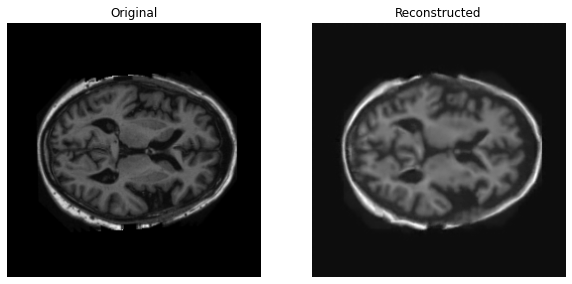

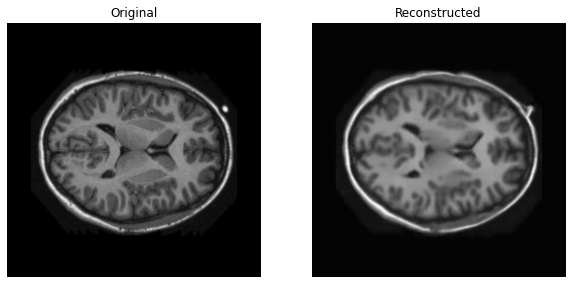

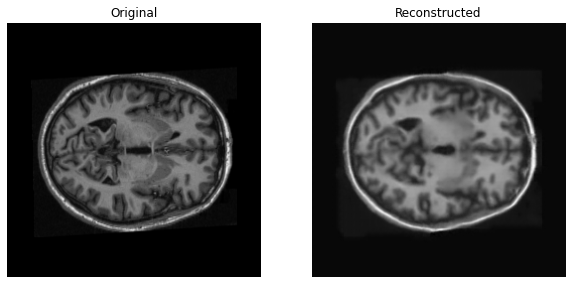

In [7]:
img_count = 3
tools.plot_images(img_count, data_test, vqvae_trainer)

### Calculate the structured similarity between the original image and the reconstructed image.

In [8]:
print(tools.mean_ssim(data_test, vqvae_trainer))

0.9885035208959136


# Train the PixelCNN model
### Preprocess the data to be loaded into pixelcnn.
For each image, pass it to the trained vqvae encoder and map the output from the encoder to the closest latent embedding vector in the latent space. Since the dataset is large, it is impossible to load all the preprocessed image into the memory. Instead, I used a generator to load the images in batch size of 32.

In [9]:
train_gen = dataset.train_codebook_generator(data_train, vqvae_trainer, batch_size = 32)

data = next(train_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)


In [10]:
valid_gen = dataset.validate_codebook_generator(data_validate, vqvae_trainer, batch_size = 32)

data = next(valid_gen)
print(data[0].shape, data[1].shape)

(32, 32, 32, 256) (32, 32, 32, 256)


In [11]:
input_shape = tools.get_cnn_shape(vqvae_trainer.encoder, data_test)[1:-1]
num_embeddings = vqvae_trainer.vq_layer.num_embeddings#256
num_residual_blocks = 7
num_pixelcnn_layers = 2
print(input_shape, num_embeddings)

(32, 32) 256


In [12]:
steps_per_epoch = len(data_train)/32
valiation_steps = len(data_validate)/32
print(steps_per_epoch)
print(valiation_steps)

302.0
35.0


### Build the pixelcnn model and train it.

In [13]:
pixel_cnn = pixelcnn.PixelCNN(num_residual_blocks, num_pixelcnn_layers, num_embeddings)
pixel_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),loss = tf.losses.CategoricalCrossentropy(from_logits = True), metrics=['accuracy'])
pixel_cnn.fit(x = train_gen, epochs = 600, validation_data = valid_gen, batch_size = 32, 
                    validation_steps = valiation_steps, validation_batch_size = 32, steps_per_epoch = steps_per_epoch)

Epoch 1/600
302/302 [==============================] - 37s 115ms/step - loss: 2.1737 - accuracy: 0.5411 - val_loss: 3.0669 - val_accuracy: 0.4895
Epoch 2/600
302/302 [==============================] - 34s 114ms/step - loss: 1.6540 - accuracy: 0.5922 - val_loss: 1.6427 - val_accuracy: 0.5937
Epoch 3/600
302/302 [==============================] - 34s 114ms/step - loss: 1.4960 - accuracy: 0.6118 - val_loss: 1.4840 - val_accuracy: 0.6138
Epoch 4/600
302/302 [==============================] - 34s 114ms/step - loss: 1.4124 - accuracy: 0.6240 - val_loss: 1.4373 - val_accuracy: 0.6193
Epoch 5/600
302/302 [==============================] - 34s 114ms/step - loss: 1.3619 - accuracy: 0.6319 - val_loss: 1.4132 - val_accuracy: 0.6223
Epoch 6/600
302/302 [==============================] - 34s 114ms/step - loss: 1.3271 - accuracy: 0.6376 - val_loss: 1.4020 - val_accuracy: 0.6239
Epoch 7/600
302/302 [==============================] - 34s 114ms/step - loss: 1.3008 - accuracy: 0.6422 - val_loss: 1.3922 -

Epoch 57/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0795 - accuracy: 0.6873 - val_loss: 1.4522 - val_accuracy: 0.6245
Epoch 58/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0785 - accuracy: 0.6876 - val_loss: 1.4550 - val_accuracy: 0.6244
Epoch 59/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0776 - accuracy: 0.6878 - val_loss: 1.4551 - val_accuracy: 0.6238
Epoch 60/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0769 - accuracy: 0.6880 - val_loss: 1.4547 - val_accuracy: 0.6247
Epoch 61/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0760 - accuracy: 0.6882 - val_loss: 1.4593 - val_accuracy: 0.6244
Epoch 62/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0748 - accuracy: 0.6884 - val_loss: 1.4633 - val_accuracy: 0.6241
Epoch 63/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0741 - accuracy: 0.6885 - val_loss: 1

302/302 [==============================] - 34s 114ms/step - loss: 1.0345 - accuracy: 0.6984 - val_loss: 1.5081 - val_accuracy: 0.6221
Epoch 113/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0339 - accuracy: 0.6986 - val_loss: 1.5117 - val_accuracy: 0.6219
Epoch 114/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0332 - accuracy: 0.6987 - val_loss: 1.5135 - val_accuracy: 0.6220
Epoch 115/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0330 - accuracy: 0.6988 - val_loss: 1.5188 - val_accuracy: 0.6216
Epoch 116/600
302/302 [==============================] - 34s 113ms/step - loss: 1.0324 - accuracy: 0.6989 - val_loss: 1.5219 - val_accuracy: 0.6212
Epoch 117/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0323 - accuracy: 0.6990 - val_loss: 1.5216 - val_accuracy: 0.6210
Epoch 118/600
302/302 [==============================] - 34s 114ms/step - loss: 1.0322 - accuracy: 0.6990 - val_loss: 1.5199 -

302/302 [==============================] - 35s 116ms/step - loss: 1.0133 - accuracy: 0.7038 - val_loss: 1.5514 - val_accuracy: 0.6199
Epoch 168/600
302/302 [==============================] - 35s 115ms/step - loss: 1.0134 - accuracy: 0.7037 - val_loss: 1.5468 - val_accuracy: 0.6202
Epoch 169/600
302/302 [==============================] - 35s 116ms/step - loss: 1.0127 - accuracy: 0.7040 - val_loss: 1.5514 - val_accuracy: 0.6199
Epoch 170/600
302/302 [==============================] - 35s 116ms/step - loss: 1.0122 - accuracy: 0.7041 - val_loss: 1.5524 - val_accuracy: 0.6200
Epoch 171/600
302/302 [==============================] - 35s 116ms/step - loss: 1.0118 - accuracy: 0.7042 - val_loss: 1.5562 - val_accuracy: 0.6196
Epoch 172/600
302/302 [==============================] - 35s 115ms/step - loss: 1.0114 - accuracy: 0.7043 - val_loss: 1.5572 - val_accuracy: 0.6197
Epoch 173/600
302/302 [==============================] - 35s 115ms/step - loss: 1.0108 - accuracy: 0.7045 - val_loss: 1.5544 -

302/302 [==============================] - 34s 113ms/step - loss: 0.9972 - accuracy: 0.7082 - val_loss: 1.6020 - val_accuracy: 0.6167
Epoch 223/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9970 - accuracy: 0.7082 - val_loss: 1.6033 - val_accuracy: 0.6169
Epoch 224/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9969 - accuracy: 0.7082 - val_loss: 1.5981 - val_accuracy: 0.6173
Epoch 225/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9967 - accuracy: 0.7082 - val_loss: 1.5953 - val_accuracy: 0.6175
Epoch 226/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9970 - accuracy: 0.7081 - val_loss: 1.5932 - val_accuracy: 0.6180
Epoch 227/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9971 - accuracy: 0.7080 - val_loss: 1.5948 - val_accuracy: 0.6181
Epoch 228/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9965 - accuracy: 0.7081 - val_loss: 1.5923 -

302/302 [==============================] - 34s 114ms/step - loss: 0.9861 - accuracy: 0.7110 - val_loss: 1.6244 - val_accuracy: 0.6175
Epoch 278/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9863 - accuracy: 0.7109 - val_loss: 1.6202 - val_accuracy: 0.6178
Epoch 279/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9860 - accuracy: 0.7110 - val_loss: 1.6273 - val_accuracy: 0.6176
Epoch 280/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9857 - accuracy: 0.7111 - val_loss: 1.6237 - val_accuracy: 0.6176
Epoch 281/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9854 - accuracy: 0.7113 - val_loss: 1.6271 - val_accuracy: 0.6174
Epoch 282/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9849 - accuracy: 0.7115 - val_loss: 1.6272 - val_accuracy: 0.6174
Epoch 283/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9845 - accuracy: 0.7115 - val_loss: 1.6218 -

302/302 [==============================] - 34s 114ms/step - loss: 0.9791 - accuracy: 0.7130 - val_loss: 1.6363 - val_accuracy: 0.6182
Epoch 333/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9790 - accuracy: 0.7130 - val_loss: 1.6416 - val_accuracy: 0.6178
Epoch 334/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9778 - accuracy: 0.7134 - val_loss: 1.6448 - val_accuracy: 0.6174
Epoch 335/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9775 - accuracy: 0.7134 - val_loss: 1.6438 - val_accuracy: 0.6181
Epoch 336/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9774 - accuracy: 0.7135 - val_loss: 1.6511 - val_accuracy: 0.6177
Epoch 337/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9769 - accuracy: 0.7137 - val_loss: 1.6496 - val_accuracy: 0.6177
Epoch 338/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9765 - accuracy: 0.7138 - val_loss: 1.6519 -

302/302 [==============================] - 34s 114ms/step - loss: 0.9725 - accuracy: 0.7148 - val_loss: 1.6767 - val_accuracy: 0.6178
Epoch 388/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9727 - accuracy: 0.7147 - val_loss: 1.6757 - val_accuracy: 0.6181
Epoch 389/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9724 - accuracy: 0.7148 - val_loss: 1.6739 - val_accuracy: 0.6183
Epoch 390/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9720 - accuracy: 0.7149 - val_loss: 1.6736 - val_accuracy: 0.6185
Epoch 391/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9715 - accuracy: 0.7151 - val_loss: 1.6712 - val_accuracy: 0.6187
Epoch 392/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9710 - accuracy: 0.7153 - val_loss: 1.6710 - val_accuracy: 0.6186
Epoch 393/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9703 - accuracy: 0.7157 - val_loss: 1.6731 -

302/302 [==============================] - 34s 114ms/step - loss: 0.9669 - accuracy: 0.7164 - val_loss: 1.6891 - val_accuracy: 0.6173
Epoch 443/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9676 - accuracy: 0.7162 - val_loss: 1.6902 - val_accuracy: 0.6174
Epoch 444/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9677 - accuracy: 0.7161 - val_loss: 1.6854 - val_accuracy: 0.6173
Epoch 445/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9668 - accuracy: 0.7164 - val_loss: 1.6821 - val_accuracy: 0.6177
Epoch 446/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9667 - accuracy: 0.7165 - val_loss: 1.6850 - val_accuracy: 0.6177
Epoch 447/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9666 - accuracy: 0.7165 - val_loss: 1.6896 - val_accuracy: 0.6173
Epoch 448/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9661 - accuracy: 0.7167 - val_loss: 1.6927 -

302/302 [==============================] - 34s 114ms/step - loss: 0.9607 - accuracy: 0.7183 - val_loss: 1.7048 - val_accuracy: 0.6175
Epoch 498/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9606 - accuracy: 0.7183 - val_loss: 1.7055 - val_accuracy: 0.6173
Epoch 499/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9607 - accuracy: 0.7182 - val_loss: 1.7050 - val_accuracy: 0.6172
Epoch 500/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9615 - accuracy: 0.7179 - val_loss: 1.7055 - val_accuracy: 0.6173
Epoch 501/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9618 - accuracy: 0.7179 - val_loss: 1.7060 - val_accuracy: 0.6169
Epoch 502/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9623 - accuracy: 0.7177 - val_loss: 1.7039 - val_accuracy: 0.6169
Epoch 503/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9623 - accuracy: 0.7175 - val_loss: 1.6973 -

302/302 [==============================] - 34s 113ms/step - loss: 0.9560 - accuracy: 0.7196 - val_loss: 1.7309 - val_accuracy: 0.6167
Epoch 553/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9555 - accuracy: 0.7198 - val_loss: 1.7315 - val_accuracy: 0.6168
Epoch 554/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9553 - accuracy: 0.7199 - val_loss: 1.7372 - val_accuracy: 0.6166
Epoch 555/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9557 - accuracy: 0.7197 - val_loss: 1.7391 - val_accuracy: 0.6165
Epoch 556/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9558 - accuracy: 0.7196 - val_loss: 1.7379 - val_accuracy: 0.6162
Epoch 557/600
302/302 [==============================] - 34s 114ms/step - loss: 0.9564 - accuracy: 0.7195 - val_loss: 1.7354 - val_accuracy: 0.6168
Epoch 558/600
302/302 [==============================] - 34s 113ms/step - loss: 0.9570 - accuracy: 0.7192 - val_loss: 1.7356 -

### Make predictions using the model.

In [14]:
#get the output shape of the encoder
train_gen_1 = dataset.train_codebook_generator(data_train, vqvae_trainer, batch_size = 1)
data = next(train_gen_1)
print(data[0].shape)
out = pixel_cnn.predict(data[0])

print(out.shape)
print(out.shape[1:])

(1, 32, 32, 256)
(1, 32, 32, 256)
(32, 32, 256)


In [36]:
# Create an empty array of priors.
batch = 5
shape = ((batch,) + out.shape[1:])
priors = tf.zeros(shape = shape)
batch, rows, cols, embedding_count = priors.shape
print(priors.shape)
# Iterate over the priors pixel by pixel.
for row in range(rows):
    for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            x = pixel_cnn(priors, training=False)
            dist = tfp.distributions.Categorical(logits=x)
            sampled = dist.sample()
            sampled = tf.one_hot(sampled,256)
            priors = sampled
print(f"Prior shape: {priors.shape}")

(5, 32, 32, 256)
Prior shape: (5, 32, 32, 256)


In [37]:
#map the one-hot encodings to actual values
embedding_dim = vqvae_trainer.vq_layer.embedding_dim
pretrained_embeddings = vqvae_trainer.vq_layer.embeddings
pixels = tf.constant(priors, dtype = "float32")

quantized = tf.matmul(pixels, pretrained_embeddings, transpose_b=True)
print(quantized.shape)

(5, 32, 32, 256)


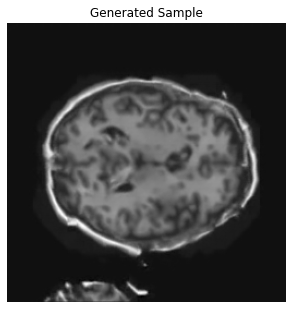

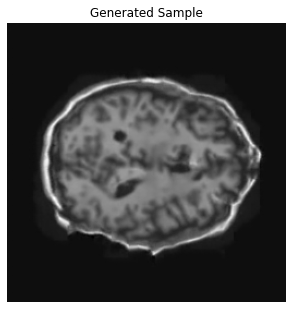

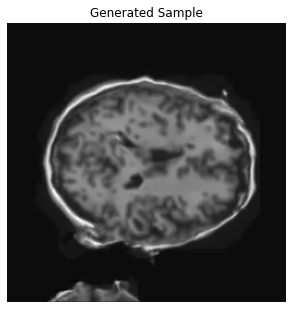

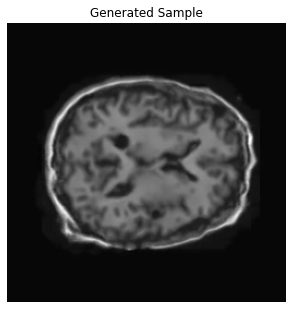

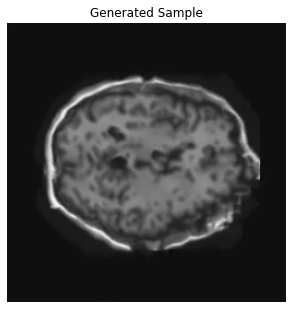

In [38]:
# Generate images.
decoder = vqvae_trainer.decoder
generated_samples = decoder.predict(quantized)
#figs = ['fig12.png','fig22.png','fig32.png','fig42.png','fig52.png','fig62.png','fig72.png','fig82.png','fig92.png','fig102.png']
figs =  ['fig1.png','fig2.png','fig3.png','fig4.png','fig5.png']
for i in range(batch):
    plt.figure(figsize = (5,6))
    plt.imshow(generated_samples[i],cmap = 'gray')
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()
    im = keras.utils.array_to_img(generated_samples[i])
    im.save(figs[i])